# K-Means , Agglomerative and DBSCAN on Amazon Fine Food Reviews DataSet:

# Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

##### The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

###### Number of reviews: 568,454
###### Number of users: 256,059
###### Number of products: 74,258
###### Timespan: Oct 1999 - Oct 2012
###### Number of Attributes/Columns in data: 10

###### Attribute Information:

###### Id - Id of the row in the dataset
###### ProductId - unique identifier for the product
###### UserId - unqiue identifier for the user
###### ProfileName - name on the profile
###### HelpfulnessNumerator - number of users who found the review helpful
###### HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
###### Score - rating between 1 and 5
###### Time - timestamp for the review
###### Summary - brief summary of the review
###### Text - text of the review
###### Objective:
######  To apply the K-Means Clustering Algorithm on the Bow , TF-IDF Vectors and computing the best K value for each Vectors and finding the word cloud for each clusters formed .

# DBSCAN Clustering:
1. Find the best ‘Eps’ using the elbow-knee method.
2. Try representing those reviews in a cluster as a word cloud so that it would be more comprehensible what a particular cluster represents.

### Step-By-Step procedure

1. In this, we need to work with all 4-vectorizers (BOW, TFIDF,Avg w2v and TF-IDF weighted w2v) where we will convert our texted review into numerical(vector) form in order to apply any Model on it.

2. After that we will take our cleandedtext(i.e cleand text means we have already cleaned our data by removing stops words, other this which are going to affect our model) and then we will take only test data not their respective class lable because as we know we are goint to apply K-means clustering algo which do not required class lables. what is does is it mainly group/clusters the similar data points

3. DBSCAN is density based clustering algo and in this we have to hyperparameters i.e min_pts and EPS what are these min_pts i.e min_samples is The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. and eps is the maximum distance between two samples for them to be considered as in the same neighborhood. and we typically try to choose larger min_points because which helps to remove the outliers 

4. We typically choose min_pts is 2*dim-of-our data and EPS using using elbow-knee methods.

5. After getting min_points and EPS we try to implement DBSCAN model with different EPS near by to best EPS and try to read and represent the reviews for each EPS 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

import sqlite3
import string
import nltk

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import re
import string
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import os
from tqdm import tqdm

from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

import warnings
warnings.filterwarnings('ignore')

# ============================== data preprocessing ===========================================
# Making the connection to the database.sqlite
con = sqlite3.connect("C:\\Users\\Ashu\\Desktop\\AAIC\\IPython Notebooks\\AMAZON Fine Food Reviews\\amazon-fine-food-reviews\\database.sqlite")





C:\Users\Ashu\Miniconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\Ashu\Miniconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Ashu\Miniconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Extracting out the positive and negative features 
amazon_featured_reviews = pd.read_sql_query("""SELECT * FROM REVIEWS WHERE SCORE != 3""" , con)

print(amazon_featured_reviews.shape)




# Creating the partition function returning the positive or negative reviews and appending them in the Score column in place 
# of ratings given:

def partition(x):
        if x < 3:
            return 0
        else :
            return 1
        
        
pos_neg_reviews_df = amazon_featured_reviews['Score'].map(partition)
print(type(pos_neg_reviews_df) , 'pos_neg_reviews_df' , pos_neg_reviews_df.shape)
print('type(amazon_featured_reviews):' , type(amazon_featured_reviews))
amazon_featured_reviews['Score'] = pos_neg_reviews_df
amazon_featured_reviews.shape
amazon_featured_reviews.head(2)


(525814, 10)
<class 'pandas.core.series.Series'> pos_neg_reviews_df (525814,)
type(amazon_featured_reviews): <class 'pandas.core.frame.DataFrame'>


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [3]:
# Data deduplication is used to clean the data having redundancy and many unwanted things which msut be removed to further
# use the data:

duplicate_df = pd.read_sql_query("""SELECT * FROM REVIEWS WHERE SCORE !=3 AND Text IN 
                                    (SELECT Text FROM REVIEWS
                                    GROUP BY Text having count(*) > 1)
                                    """ , con)
duplicate_df.head(4)

#So we can see there are many such duplicated rows having some column values similar to each other

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
1,11,B0001PB9FE,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
2,30,B0001PB9FY,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
3,70,B000E7VI7S,AWCBF2ZWIN57F,C. Salcido,0,2,5,1185753600,pretzel haven!,this was sooooo deliscious but too bad i ate e...


In [4]:
#Doing some other check using the below query to see whether such reduncdancy is over small scale or a large scale of rows:
# From count(*) values we can see that we have so much of redundant data, so it has to be cleaned.
dup_data = pd.read_sql_query("""
select ID,ProductID,USERID , PROFILENAME , Summary ,text ,count(*) AS COUNT
FROM REVIEWS
GROUP BY PRODUCTID,SUMMARY,TEXT  
having count(*) > 1""",con)
dup_data.head(6)

,Id,ProductId,UserId,ProfileName,Summary,Text,COUNT
0,171154,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",best dog treat-- great for training--- all do...,Freeze dried liver has a hypnotic effect on do...,2
1,217385,7310172101,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",best dog treat-- great for training--- all do...,Freeze dried liver has a hypnotic effect on do...,2
2,369857,B000084DWM,A3TVZM3ZIXG8YW,christopher hayes,"Filler food is empty, leaves your cat always n...","This review will make me sound really stupid, ...",10
3,369801,B000084DWM,A36JDIN9RAAIEC,Jon,"Great product, but trust your vet not the hype","I have two cats, one 6 and one 2 years old. Bo...",2
4,410265,B000084EZ4,A2FGXWWR8ZU59C,Thomas Lawrence,"Cats love the food, but no pull-tab top, and d...","I appreciate being able to buy this larger, mo...",2
5,410304,B000084EZ4,A29JUMRL1US6YP,HTBK,Fantastic Food for Good Cat Health,The pet food industry can be one of the most i...,4


In [5]:
# Let's see another case:

dup_data = pd.read_sql_query("""SELECT * FROM REVIEWS
                                    WHERE SCORE != 3 AND UserId = "AJD41FBJD9010" AND ProductID="7310172001"
                                    Order by ProductID""" , con)
dup_data


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,171152,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",0,0,5,1233360000,dogs LOVE it-- best treat for rewards and tra...,Freeze dried liver has a hypnotic effect on do...
1,171153,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",0,0,5,1233360000,best dog treat-- great for training--- all do...,Freeze dried liver has a hypnotic effect on do...
2,171154,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",0,0,5,1233360000,best dog treat-- great for training--- all do...,Freeze dried liver has a hypnotic effect on do...
3,171189,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",39,51,5,1233360000,NO waste at all ---- great for training ----...,Freeze dried liver has a hypnotic effect on do...
4,171223,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",1,1,5,1233360000,best dog treat-- great for training--- all do...,Freeze dried liver has a hypnotic effect on do...
5,171228,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",5,7,5,1233360000,NO waste at all--- all dogs love liver treats-...,Freeze dried liver has a hypnotic effect on do...


# Observation:

####    In above Analysis what we found is :
###### There are product's having the same productID's with same {'TEXT'} , {'Timestamp'} , {'UserID'}
###### There are products having the different productID's with same {'TEXT'} , {'Timestamp'} , {"helpfullnessNumerator"} , {"HelpfullnessNumerator"} 
##### We termed such type of the data in our data set as Redundant Data , so we perform various cleaning methods to remove them from
###### the Data Set.

In [6]:
#Removing the Duplicate data points:

duplicated_data = amazon_featured_reviews.duplicated(subset={'UserId','ProfileName','Time','Summary','Text'} , keep='first')
duplicated_data = pd.DataFrame(duplicated_data , columns=['Boolean'])
print(duplicated_data.head(5))

#True values in the Boolean Series represents the duplicate data:
print(duplicated_data['Boolean'].value_counts(dropna=False)) #gives me the total no of the duplicates

#The total no of duplicates here in the amazon_featured_reviews are:
print("total no of duplicates here in the amazon_featured_reviews are:",duplicated_data[duplicated_data['Boolean']==True].count())

#dropping the duplicates:
final = amazon_featured_reviews.sort_values(by='ProductId',kind='quicksort',ascending=True,inplace=False)
final = final.drop_duplicates(subset={'UserId','ProfileName','Time','Text'} , keep='first', inplace=False)
print('\n','DataFrame final shape before removing helpfullness data :', final.shape)

#Also removing the instances where HelpfulnessNumerator >= HelpfulnessDenominator:
final = final[final['HelpfulnessNumerator'] <= final['HelpfulnessDenominator']]
print('final', final.shape)


   Boolean
0    False
1    False
2    False
3    False
4    False
False    365333
True     160481
Name: Boolean, dtype: int64
total no of duplicates here in the amazon_featured_reviews are: Boolean    160481
dtype: int64

 DataFrame final shape before removing helpfullness data : (364173, 10)
final (364171, 10)


In [7]:
#Finding the books data in the amazon_featured_reviews using the regex:
import re
print(final.columns)
def analyzing_summary_book(filtered_data , regex):
    
    mask_summary = filtered_data.Summary.str.lower().str.contains(regex) 
    mask_text =    filtered_data.Text.str.lower().str.contains(regex)
    print(len(filtered_data[mask_summary].index) , len(filtered_data[mask_text].index))
    print('initial shape of the filtered_data' , filtered_data.shape)
    filtered_data.drop(filtered_data[mask_summary].index , inplace=True , axis=0)
    filtered_data.drop(filtered_data[mask_text].index , axis=0 , inplace=True)


Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


In [8]:
#Removing the Books reviews we get below final dataframe:
#On observation of some of the reviews we got certain keywords related to books,reading ,poems , story,learn , study , music 
#So we removed these words as much as possible:


print('final shape before removing books reviews:' , final.shape)
analyzing_summary_book(final , re.compile(r'reading|books|book|read|study|learn|poems|music|story'))

print('final shape after removing the book reviews:' , final.shape)

final shape before removing books reviews: (364171, 10)
2842 36649
initial shape of the filtered_data (364171, 10)
final shape after removing the book reviews: (326808, 10)


In [9]:
#Computing the proportion of positive and negative class labels in the DataFrame:
final['Score'].value_counts()

1    276668
0     50140
Name: Score, dtype: int64

In [10]:
import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

stop = set(stopwords.words('english'))
print(stop)
print('\n' , 'length of stopwords set' , len(stop))

print("*" * 30)

sno = SnowballStemmer('english')

{'further', 're', 'then', 'doesn', 'ours', 'these', "shouldn't", 'm', 'doing', 'by', 'having', 'and', 'more', 'itself', 'where', 'didn', "she's", 'at', 'to', 'before', 'do', 'not', 'off', 'll', 'y', 'your', "you'd", "don't", 'haven', 'when', 'yours', 'who', 'shouldn', 'wasn', 'its', 'as', 'have', 'on', 'once', 'are', "wouldn't", 'such', 'had', 'other', 'only', "it's", "wasn't", 'my', 'weren', 'with', 'can', 'those', 'you', "won't", 'am', "haven't", 'hadn', "you'll", 'of', 'a', 'above', 'so', 'hasn', 'an', "doesn't", 'no', 'does', 'won', 'same', 'o', 'our', 'shan', 'any', 'from', 'over', "weren't", 'if', 'between', "mustn't", 'after', 'is', 'should', 'will', 'yourselves', 'couldn', 'he', "should've", 'down', 'very', 'her', 'out', 'herself', 'it', "didn't", 'all', 'isn', 'or', 'himself', 'up', 'below', 'which', 'him', 'but', 'why', "mightn't", 'needn', 'while', 'the', 'ourselves', 'myself', 'yourself', 'some', 'don', 'his', 'their', 'own', "needn't", 'here', 'just', 'has', 'wouldn', 'int

# Observation:
#### We found many redundancy in the data set and some of the Books data which does not make any sense here.
##### We dropped the almost 160K records in data de duplication step.

# Text Preprocessing : 
### Removing Removing html tags
### Removing Punctuation charcaters
### Alphanumeric numbers 
### Length of words must be > 2  
### Uppercase to Lowercase
### Removing the stop words
### Using the Snowball Stemmer.  

In [11]:
# Functions to clean the html tags and punctuation marks using Regular Expression.

def clean_htmlTags(sentence):
    pattern = re.compile('<.*?>')
    cleaned_text = re.sub(pattern , '' , sentence)
    return cleaned_text

def clean_punc(sentence):
    cleaned = re.sub(r'[!|#|,|?|\'|"]' , r' ' , sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]' ,r' ' , cleaned)
    return cleaned


In [12]:
#The below code will remove all the html tags , punctuation marks , uppercase to lowercase conversion only if length of the words
# are greater than 2 and are alphanumeric . Further we perform the Stemming of the each word in the each document.

all_positive_words = []
all_negative_words = []
i = 0
str_temp = ' '
final_string = []
for sent in final['Text'].values:
    filtered_sentence=[]
    sent = clean_htmlTags(sent)
    for w in sent.split():
        for clean_word in clean_punc(w).split():
            if((clean_word.isalpha()) and (len(clean_word) > 2)):
                if(clean_word.lower() not in stop):
                    s = (sno.stem(clean_word.lower())).encode('utf-8')
                    filtered_sentence.append(s)
                    if((final['Score'].values)[i] == 'positive'):
                        all_positive_words.append(s)
                    if((final['Score'].values)[i] == 'negative'):
                        all_negative_words.append(s)
                else:
                    continue
            else:
                continue

    str_temp = b" ".join(filtered_sentence)
    final_string.append(str_temp)
    i+=1

In [13]:
#Now I have a final_string of list of each review and append it to the new columns of the final data frame:

final['CleanedText'] = final_string
final['CleanedText'] = final['CleanedText'].str.decode('utf-8')
final.shape


(326808, 11)

In [14]:
#Making backup of th pre processed data for the future use:
final_backup = final

In [15]:

final_backup.shape #to use the dataframe in future if required

(326808, 11)

In [75]:
#Now lets take roughly same proportion of  each of positive and negative review from the data set for faster processing 
#the further data:
#We can process our next tasks with whole amount of the data but we are bounded with time and memory spaces so we have used


# To sample 80K points :

final_clean = final.iloc[:5000:]
print(final_clean.shape)
print(final_clean['Score'].value_counts())


(5000, 11)
1    4171
0     829
Name: Score, dtype: int64


In [76]:
#Sort the final data frame by timestamp values:
final_clean['Time'] = pd.to_datetime(final['Time'],unit='s')
final_clean = final_clean.sort_values(by='Time')
final_clean.shape

(5000, 11)

## DBSCAN Algorithm Implementation:


In [77]:
from sklearn.cluster import DBSCAN


text_reviews = final['Text'].values

#The below function will find the Kth distance to the points in the cluster:
def Kth_neighbour_distance(vect , n):
    distance_matrix = []
    for p in vect:
        p_vect_distance = np.sort(np.sum((vect - p)**2,axis=1),axis=None)
        
        distance_matrix.append(p_vect_distance[n])
    return np.sqrt(np.array(distance_matrix))



from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def cluster_wordcloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100,stopwords=stopwords ,background_color="white").generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [109]:
text_reviews = final['Text'].values
#We can see some of the labels in the DBSCAN model is -1 which represent the noisy data so we will compute the cluster for 
# the noisy data too and represent the reviews in them in a wordcloud.

def DBSCAN_implementation_different_eps(n_eps , min_pts , vector):
    
    for eps_val in n_eps:
        model = DBSCAN(eps=eps_val, min_samples=min_pts).fit(vector)
        print("*" * 30, "DBSCAN with EPS = ", eps_val, "  ", "*" * 30)
        
        clusters_list = list(set(model.labels_))
        
        #finding the length of the cluster:
        n_clusters = len(set(model.labels_))
        
        print("DBSCAN with EPS =%.3f and min_pts = %d the no. of Clusters = %d"%(eps_val,min_pts,n_clusters))
        
        
        for cluster in clusters_list:
            review_count = 1
            print("*" * 100)
            
            if cluster == -1:
                print("Noisy point label in cluster - ",cluster)
            else:
                print("Reviews of cluster = ",cluster+1)
                print("*" * 100)
                
            for i in range(model.labels_.shape[0]):
                if model.labels_[i] == cluster:
                    if review_count == 3:
                        break;
                    else:
                        print('Review - ',review_count)
                        print(text_reviews[i])
                        cluster_wordcloud(text_reviews[i])
                        review_count += 1
        
        print("*" * 100)
        print("\n")


#### BAG OF WORDS:


In [97]:
# Creating the training data :
X = final_clean['CleanedText']
y = final_clean['Score']
print(X.shape , y.shape)


(5000,) (5000,)


In [98]:
# Computing the Train Vectorizer :
count_vect = CountVectorizer(ngram_range=(1,1) , min_df=200)
X_bow = count_vect.fit_transform(X)
print(X_bow.shape)
type(X_bow)

(5000, 148)


scipy.sparse.csr.csr_matrix

### Find the best ‘Eps’ using the elbow-knee method.(BoW)

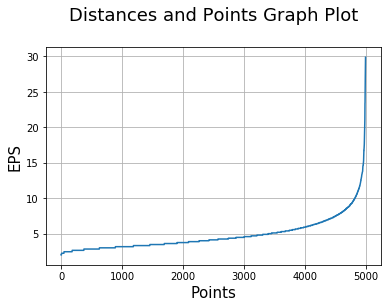

In [81]:
#bow_data.shape[1]
min_pts = 2*X_bow.shape[1]

# Computing the  distances for nth-nearest neighbours:
dist_matrix = Kth_neighbour_distance(X_bow.toarray(),min_pts)

dist_sorted = np.sort(dist_matrix)

X_points = [x for x in range(X_bow.shape[0])]

# Plotting Distance(Eps or Kth distances) VS points:

plt.plot(X_points, dist_sorted)
plt.xlabel('Points',size=15)
plt.ylabel('EPS',size=15)
plt.title('Distances and Points Graph Plot\n',size=18)
plt.grid()
plt.show()

### Implementing DBSCAN
So after getting best EPS lets try different nearby eps to see that the change in eps what will happen to our clusters 

****************************** DBSCAN with EPS =  8    ******************************
DBSCAN with EPS =8.000 and min_pts = 296 the no. of Clusters = 2
****************************************************************************************************
Reviews of cluster =  1
****************************************************************************************************
Review -  1
This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!


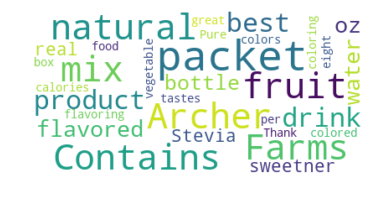

Review -  2
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


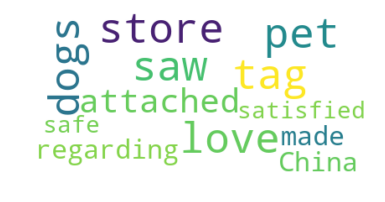

****************************************************************************************************
Noisy point label in cluster -  -1
Review -  1
Dogs just love Freeze dried liver and this is a good price for this size container.


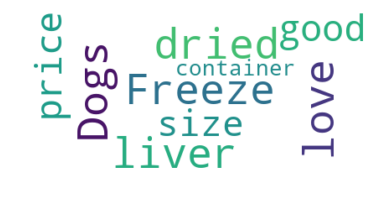

Review -  2
My 5 month old lab goes nuts over these liver treats.  Our vet recommended these as a healthy treat.  Our pup acts like a cat with catnip over these. A big hit. The price and size are excellent and should last a good while.


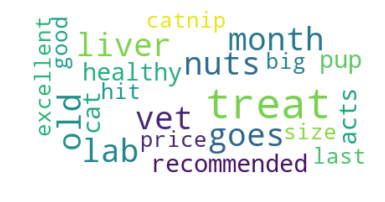

****************************************************************************************************


****************************** DBSCAN with EPS =  10    ******************************
DBSCAN with EPS =10.000 and min_pts = 296 the no. of Clusters = 2
****************************************************************************************************
Reviews of cluster =  1
****************************************************************************************************
Review -  1
This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!


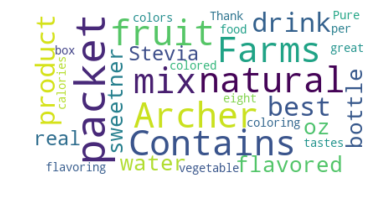

Review -  2
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


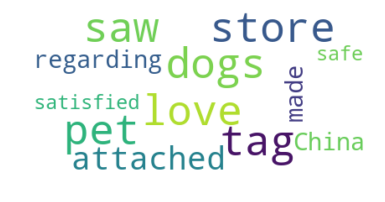

****************************************************************************************************
Noisy point label in cluster -  -1
Review -  1
Dogs just love Freeze dried liver and this is a good price for this size container.


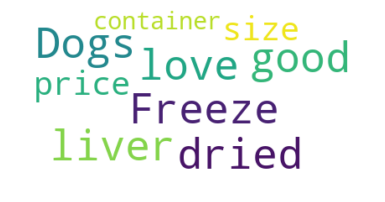

Review -  2
<a href="http://www.amazon.com/gp/product/B001AGXEAG">Beetlejuice (20th Anniversary Deluxe Edition)</a>I am very impressed with the new transfer of this film. The features are not that great but the cartoon series was pretty cool. I am interested to find out how good the blu-ray version is. Sweet dvd!!!


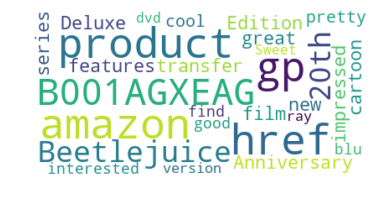

****************************************************************************************************


****************************** DBSCAN with EPS =  12    ******************************
DBSCAN with EPS =12.000 and min_pts = 296 the no. of Clusters = 2
****************************************************************************************************
Reviews of cluster =  1
****************************************************************************************************
Review -  1
This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!


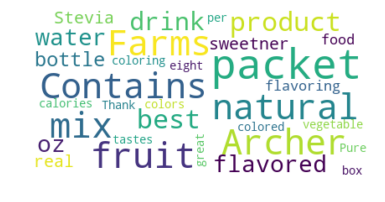

Review -  2
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


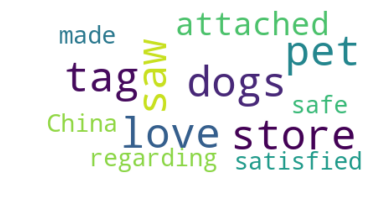

****************************************************************************************************
Noisy point label in cluster -  -1
Review -  1
Dogs just love Freeze dried liver and this is a good price for this size container.


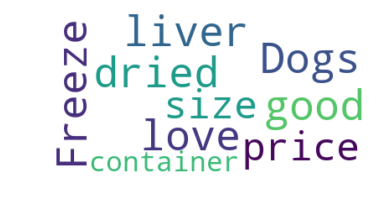

Review -  2
Just wanted to post a correction to what the previous review said...<br /><br />The film is NOT based on the cartoon it's the other way around. The cartoon came later.


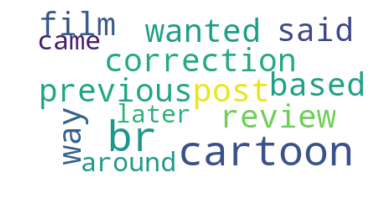

****************************************************************************************************


****************************** DBSCAN with EPS =  14    ******************************
DBSCAN with EPS =14.000 and min_pts = 296 the no. of Clusters = 2
****************************************************************************************************
Reviews of cluster =  1
****************************************************************************************************
Review -  1
This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!


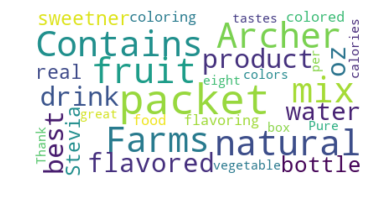

Review -  2
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


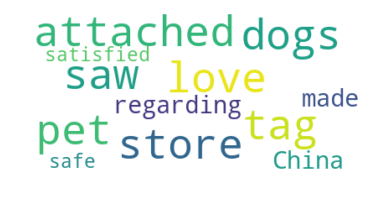

****************************************************************************************************
Noisy point label in cluster -  -1
Review -  1
Just wanted to post a correction to what the previous review said...<br /><br />The film is NOT based on the cartoon it's the other way around. The cartoon came later.


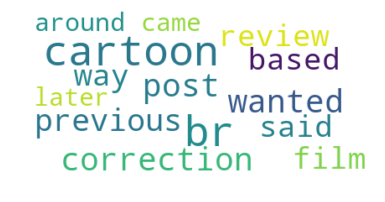

Review -  2
Great product.  The best way to kill a mole.  I bought these traps on-line only because I couldn't find them in the stores.  I've killed 3 this month.  6 for the summer.  Well worth the money.


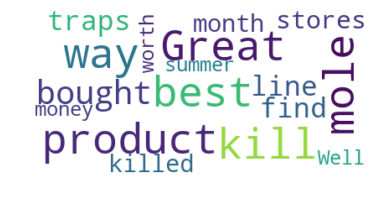

****************************************************************************************************


****************************** DBSCAN with EPS =  15    ******************************
DBSCAN with EPS =15.000 and min_pts = 296 the no. of Clusters = 2
****************************************************************************************************
Reviews of cluster =  1
****************************************************************************************************
Review -  1
This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!


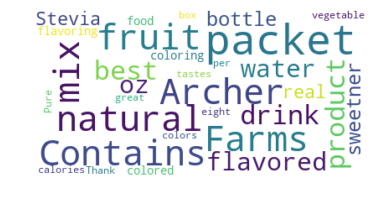

Review -  2
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


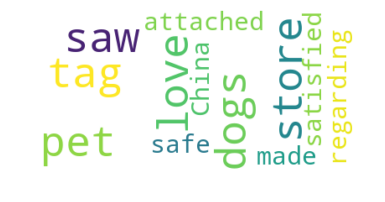

****************************************************************************************************
Noisy point label in cluster -  -1
Review -  1
Just wanted to post a correction to what the previous review said...<br /><br />The film is NOT based on the cartoon it's the other way around. The cartoon came later.


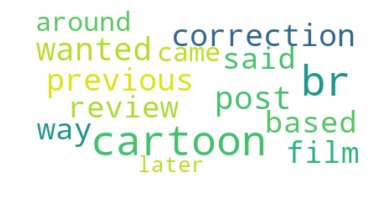

Review -  2
Great product.  The best way to kill a mole.  I bought these traps on-line only because I couldn't find them in the stores.  I've killed 3 this month.  6 for the summer.  Well worth the money.


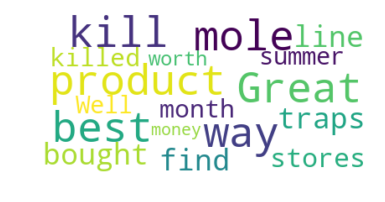

****************************************************************************************************




In [110]:
eps_list = [8,10,12,14,15]
DBSCAN_implementation_different_eps(eps_list,min_pts,X_bow.toarray())


# TF-idf vector using Dataset :

In [129]:
#Uni Gram  Train dataset Tf-IDF Vector:
tfidf_vector = TfidfVectorizer(min_df=200 )
X_tfidf= tfidf_vector.fit_transform(X)

print('X_tfidf.get_shape() : ' , X_tfidf.get_shape())

X_tfidf.get_shape() :  (5000, 148)


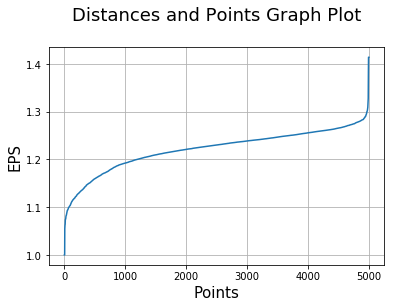

In [130]:
#bow_data.shape[1]
min_pts = 2*X_tfidf.shape[1]

# Computing the  distances for nth-nearest neighbours:
dist_matrix = Kth_neighbour_distance(X_tfidf.toarray(),min_pts)

dist_sorted = np.sort(dist_matrix)

X_points = [x for x in range(X_tfidf.shape[0])]

# Plotting Distance(Eps or Kth distances) VS points:

plt.plot(X_points, dist_sorted)
plt.xlabel('Points',size=15)
plt.ylabel('EPS',size=15)
plt.title('Distances and Points Graph Plot\n',size=18)
plt.grid()
plt.show()

****************************** DBSCAN with EPS =  0.5    ******************************
DBSCAN with EPS =0.500 and min_pts = 296 the no. of Clusters = 1
****************************************************************************************************
Noisy point label in cluster -  -1
Review -  1
This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!


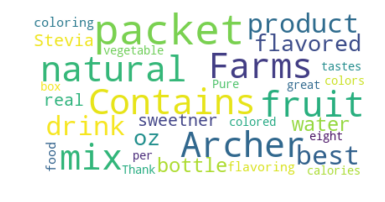

Review -  2
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


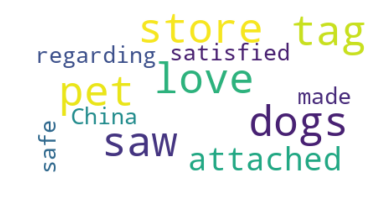

****************************************************************************************************


****************************** DBSCAN with EPS =  0.8    ******************************
DBSCAN with EPS =0.800 and min_pts = 296 the no. of Clusters = 1
****************************************************************************************************
Noisy point label in cluster -  -1
Review -  1
This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!


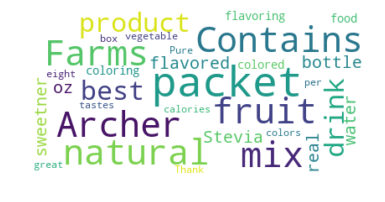

Review -  2
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


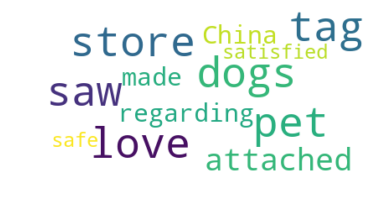

****************************************************************************************************


****************************** DBSCAN with EPS =  1.2    ******************************
DBSCAN with EPS =1.200 and min_pts = 296 the no. of Clusters = 1
****************************************************************************************************
Reviews of cluster =  1
****************************************************************************************************
Review -  1
This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!


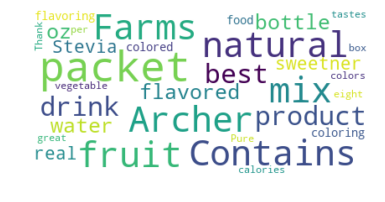

Review -  2
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


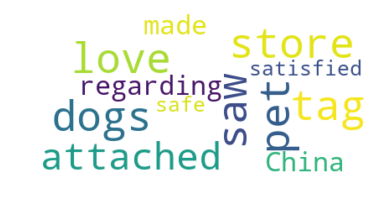

****************************************************************************************************


****************************** DBSCAN with EPS =  2    ******************************
DBSCAN with EPS =2.000 and min_pts = 296 the no. of Clusters = 1
****************************************************************************************************
Reviews of cluster =  1
****************************************************************************************************
Review -  1
This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!


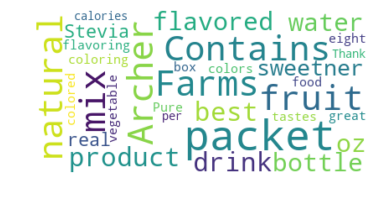

Review -  2
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


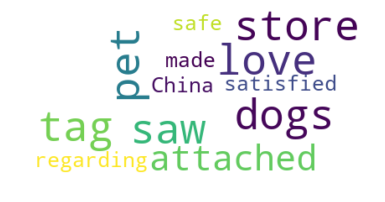

****************************************************************************************************


****************************** DBSCAN with EPS =  3    ******************************
DBSCAN with EPS =3.000 and min_pts = 296 the no. of Clusters = 1
****************************************************************************************************
Reviews of cluster =  1
****************************************************************************************************
Review -  1
This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!


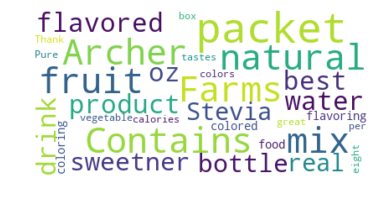

Review -  2
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


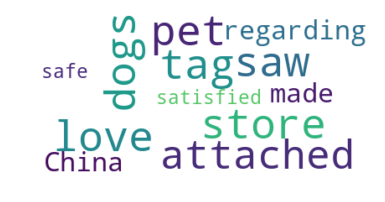

****************************************************************************************************




In [131]:
eps_list = [0.5,0.8,1.2,2,3]
DBSCAN_implementation_different_eps(eps_list,min_pts,X_tfidf.toarray())

## Word2Vec

In [114]:
# Lets compute a list of words for Train Data to compute the word2vec:
# Now we will Train our own model using Word2vec:
list_of_sentence=[]
for sent in X:
    list_of_sentence.append(sent.split())

print(list_of_sentence[0])

['beetlejuic', 'well', 'written', 'movi', 'everyth', 'excel', 'act', 'special', 'effect', 'delight', 'chose', 'view', 'movi']


In [115]:
# Creating the gensim model
import gensim
import warnings
warnings.filterwarnings('ignore')

model = gensim.models.Word2Vec(list_of_sentence , min_count=5 , size=200 , workers=4)
vocab_list = list(model.wv.vocab)

In [116]:
#Computing the Average word2vec for Data:
sent_vect= [] #this will hold the all values of the vectors of each words
for sen in tqdm(list_of_sentence):
    sen_vec = np.zeros(200) 
    word_count=0
    for word in sen:
        if word in vocab_list:
            vector_of_current_word = model.wv[word]
            sen_vec+=vector_of_current_word
            word_count+=1
    if word_count != 0:
        sen_vec/=word_count
    sent_vect.append(sen_vec)

print(len(sent_vect))

print(len(sent_vect[0]))
        

100%|█████████████████████████████████████| 5000/5000 [00:12<00:00, 405.18it/s]


5000
200


In [117]:
sent_vect = np.array(sent_vect)
type(sent_vect)

numpy.ndarray

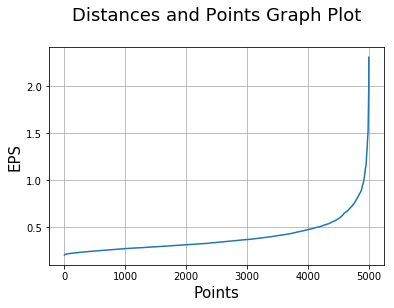

In [118]:
#bow_data.shape[1]
min_pts = 2*sent_vect[0].shape[0]

# Computing the  distances for nth-nearest neighbours:
dist_matrix = Kth_neighbour_distance(sent_vect,min_pts)

dist_sorted = np.sort(dist_matrix)

X_points = [x for x in range(len(sent_vect))]

# Plotting Distance(Eps or Kth distances) VS points:

plt.plot(X_points, dist_sorted)
plt.xlabel('Points',size=15)
plt.ylabel('EPS',size=15)
plt.title('Distances and Points Graph Plot\n',size=18)
plt.grid()
plt.show()

****************************** DBSCAN with EPS =  0.5    ******************************
DBSCAN with EPS =0.500 and min_pts = 296 the no. of Clusters = 2
****************************************************************************************************
Reviews of cluster =  1
****************************************************************************************************
Review -  1
This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!


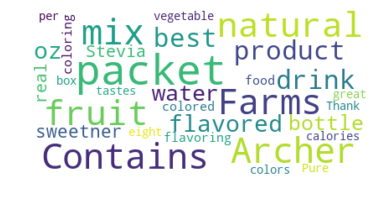

Review -  2
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


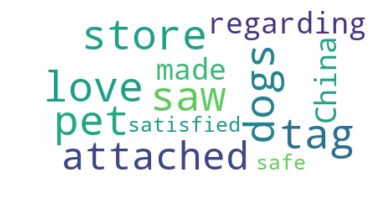

****************************************************************************************************
Noisy point label in cluster -  -1
Review -  1
okay, it's freeze-dried liver cube-lets.  my common sense tells me that for a lot less than the price of this treat i could buy real liver, cube it and freeze it.  it would serve the same purpose for a lot less money, and it would not be over-processed.<br />that said, our dog would do back flips for this treat, so if you're made of money, go ahead.  you'll make your dog's day  :-)


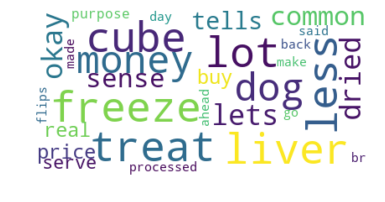

Review -  2
awesome<br /><br />I've been watching Beatlejuice for as long as i can remember. ive seen it so many times its now easy for me to quote lines. this is a great humorous movie that will forever and always be even better the more times i watch it. definately a classic.<br /><br />Michael Keaton is ghoulishly funny in this wonderful blend of horror and humor. Enjoyable family viewing on a Halloween night. Invite the neighborhood goblins over.


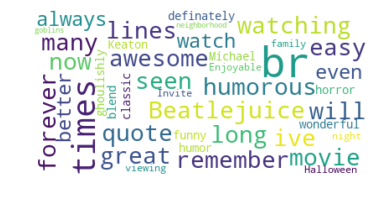

****************************************************************************************************


****************************** DBSCAN with EPS =  0.7    ******************************
DBSCAN with EPS =0.700 and min_pts = 296 the no. of Clusters = 2
****************************************************************************************************
Reviews of cluster =  1
****************************************************************************************************
Review -  1
This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!


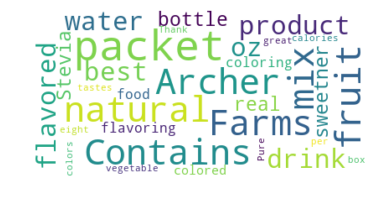

Review -  2
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


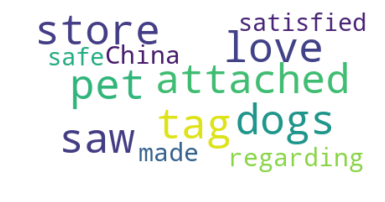

****************************************************************************************************
Noisy point label in cluster -  -1
Review -  1
okay, it's freeze-dried liver cube-lets.  my common sense tells me that for a lot less than the price of this treat i could buy real liver, cube it and freeze it.  it would serve the same purpose for a lot less money, and it would not be over-processed.<br />that said, our dog would do back flips for this treat, so if you're made of money, go ahead.  you'll make your dog's day  :-)


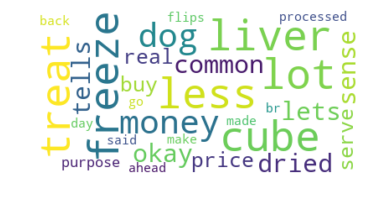

Review -  2
I love this little gizmo. I wouldn't expect it to rid you of fleas all on its own, but it is a great assist. I think it is most valuable in letting you know how effective your other efforts are, because if you have fleas, they *will* find their way into this trap. When I first started treating this season, I put this trap out. Overnight, it was covered in fleas, just like in the product pictures. As things started to get better, I noticed a decrease in how many fleas were being trapped. The last time I changed a disk, I caught several moths and such and one flea. Success!!!<br />I recommend <a href="http://www.amazon.com/gp/product/B001VJ3FP6">SentryHOME Household Flea and Tick Spray, 20-Ounce</a> and <a href="http://www.amazon.com/gp/product/B0051GCTAW">Fiproguard Fiproguard Topical Flea and Tick for Cats, All Weights</a> as two of the most effective products for ridding your home of fleas.


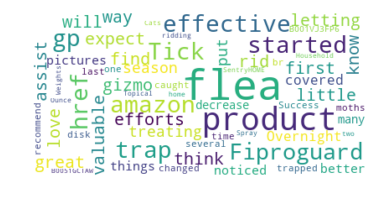

****************************************************************************************************


****************************** DBSCAN with EPS =  1.2    ******************************
DBSCAN with EPS =1.200 and min_pts = 296 the no. of Clusters = 2
****************************************************************************************************
Reviews of cluster =  1
****************************************************************************************************
Review -  1
This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!


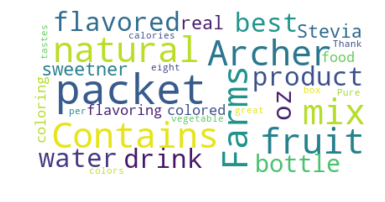

Review -  2
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


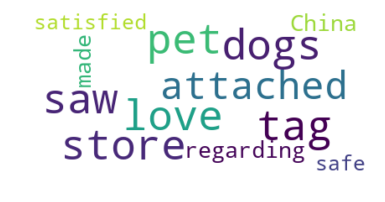

****************************************************************************************************
Noisy point label in cluster -  -1
Review -  1
I love this little gizmo. I wouldn't expect it to rid you of fleas all on its own, but it is a great assist. I think it is most valuable in letting you know how effective your other efforts are, because if you have fleas, they *will* find their way into this trap. When I first started treating this season, I put this trap out. Overnight, it was covered in fleas, just like in the product pictures. As things started to get better, I noticed a decrease in how many fleas were being trapped. The last time I changed a disk, I caught several moths and such and one flea. Success!!!<br />I recommend <a href="http://www.amazon.com/gp/product/B001VJ3FP6">SentryHOME Household Flea and Tick Spray, 20-Ounce</a> and <a href="http://www.amazon.com/gp/product/B0051GCTAW">Fiproguard Fiproguard Topical Flea and Tick for Cats, All Weights</a> as two of the mos

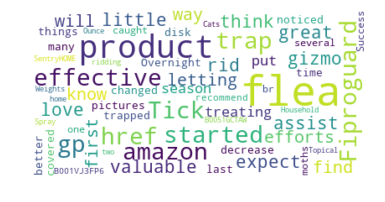

****************************************************************************************************


****************************** DBSCAN with EPS =  1.4    ******************************
DBSCAN with EPS =1.400 and min_pts = 296 the no. of Clusters = 1
****************************************************************************************************
Reviews of cluster =  1
****************************************************************************************************
Review -  1
This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!


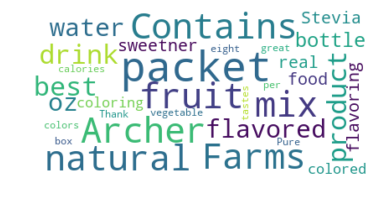

Review -  2
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


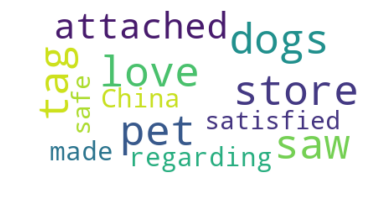

****************************************************************************************************


****************************** DBSCAN with EPS =  1.5    ******************************
DBSCAN with EPS =1.500 and min_pts = 296 the no. of Clusters = 1
****************************************************************************************************
Reviews of cluster =  1
****************************************************************************************************
Review -  1
This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!


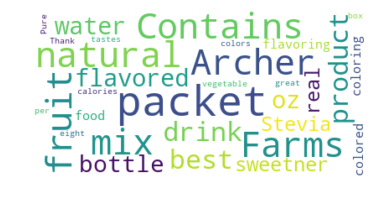

Review -  2
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


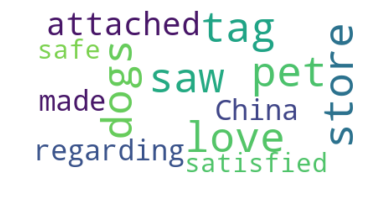

****************************************************************************************************




In [132]:
eps_list = [0.5,0.7,1.2,1.4,1.5]
DBSCAN_implementation_different_eps(eps_list,min_pts,sent_vect)

# TF-idf W2vec :

In [120]:
#Computing the TF-idf values for the Train Data:
tfidf_model = TfidfVectorizer()
tf_idf_matrix = tfidf_model.fit_transform(X)

# we are converting a dictionary with word as a key, and the tfidf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))

In [121]:
# Creating the gensim model
model = gensim.models.Word2Vec(list_of_sentence , min_count=5 , size=200 , workers=4)
vocab_list = list(model.wv.vocab)

In [122]:
# TF-IDF weighted Word2Vec
tfidf_feat = tfidf_model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentence): # for each review/sentence 
    sent_vec = np.zeros(200) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in vocab_list:
            vec = model.wv[word]
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    
print('\n' , len(tfidf_sent_vectors))

print(len(tfidf_sent_vectors[0]))

100%|█████████████████████████████████████| 5000/5000 [00:17<00:00, 290.29it/s]



 5000
200


In [123]:
#Converting the type of tfidf_sent_vectors_train to ndarray:
tfidf_sent_vectors = np.array(tfidf_sent_vectors)
type(tfidf_sent_vectors)

numpy.ndarray

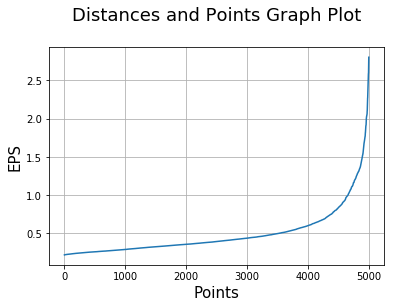

In [124]:
#bow_data.shape[1]
min_pts = 2*tfidf_sent_vectors[0].shape[0]

# Computing the  distances for nth-nearest neighbours:
dist_matrix = Kth_neighbour_distance(tfidf_sent_vectors,min_pts)

dist_sorted = np.sort(dist_matrix)

X_points = [x for x in range(len(tfidf_sent_vectors))]

# Plotting Distance(Eps or Kth distances) VS points:

plt.plot(X_points, dist_sorted)
plt.xlabel('Points',size=15)
plt.ylabel('EPS',size=15)
plt.title('Distances and Points Graph Plot\n',size=18)
plt.grid()
plt.show()

****************************** DBSCAN with EPS =  0.7    ******************************
DBSCAN with EPS =0.700 and min_pts = 296 the no. of Clusters = 2
****************************************************************************************************
Reviews of cluster =  1
****************************************************************************************************
Review -  1
This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!


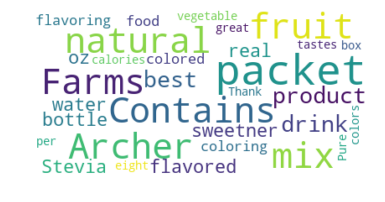

Review -  2
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


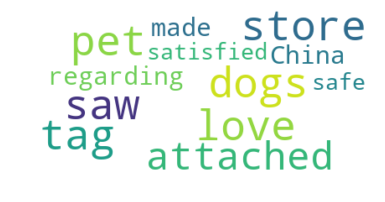

****************************************************************************************************
Noisy point label in cluster -  -1
Review -  1
This is the only dog treat that my terrier will eat. We crumble over his dry food and he LOVES it.


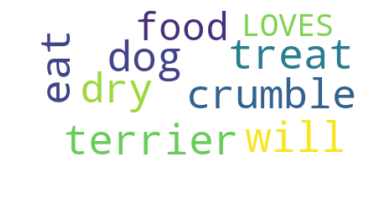

Review -  2
I have a 2 1/2 year old black lab and these are her favorite treats! They are the best for training, my dog will do just about anything to get one of these treats. Even my 3 month old black lab puppy goes running to his kennel when I tell him to go to bed because he knows that a liver treat is coming his way. Since they are sliced small a large container of these will last a while. The only complaint I have is that my dog loves these so much that if she knows shes getting one she starts to drool, and she's not a drooler... So I gotta toss one to her quick!!


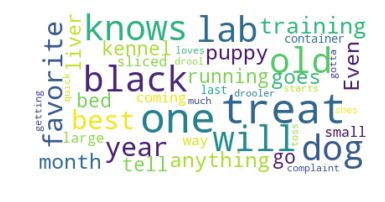

****************************************************************************************************


****************************** DBSCAN with EPS =  1.2    ******************************
DBSCAN with EPS =1.200 and min_pts = 296 the no. of Clusters = 2
****************************************************************************************************
Reviews of cluster =  1
****************************************************************************************************
Review -  1
This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!


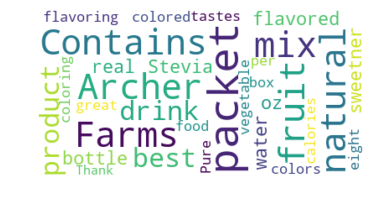

Review -  2
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


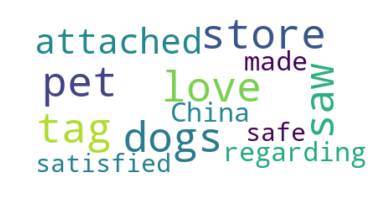

****************************************************************************************************
Noisy point label in cluster -  -1
Review -  1
I have no idea what all those people are saying but these bars don't taste that great...it is full of sugar and high fructose corn syrup. I much prefer luna bars or the south beach meal bars--which all taste tons better and are healthier.


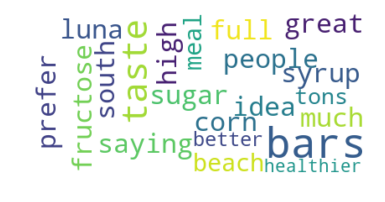

Review -  2
We moved from Science Diet lamb and Rice to Diamond Beef and Rice.  Our dog, a 8 year old 75lb Rhodesian Ridgeback, enjoys the food (she enjoys all food.)and we're feeding her the same amount as before with no changes in weight since the switch.  We're on our 2nd bag and I believe this is a good quality mid grade food and we will continue to use it as it offers good nutrition at a great value.  I appreciate more than anything that Diamond has not increased price by reducing the weight of the bag.  10 years ago a 40lb bag was standard and now most brands are selling their "big bags at 35lbs or even less.  Just like with people food, price increases are often disguised with reduced quantity in similar packaging.  Bravo to Diamond for not jumping on that bandwagon!


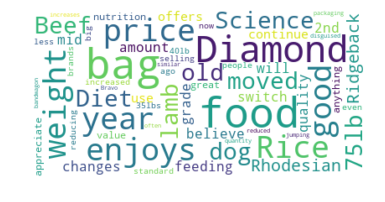

****************************************************************************************************


****************************** DBSCAN with EPS =  1.4    ******************************
DBSCAN with EPS =1.400 and min_pts = 296 the no. of Clusters = 1
****************************************************************************************************
Reviews of cluster =  1
****************************************************************************************************
Review -  1
This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!


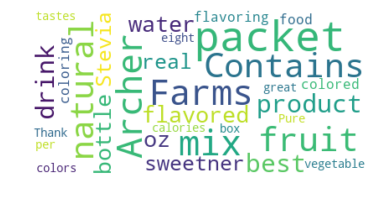

Review -  2
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


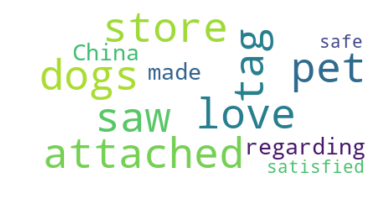

****************************************************************************************************


****************************** DBSCAN with EPS =  1.5    ******************************
DBSCAN with EPS =1.500 and min_pts = 296 the no. of Clusters = 1
****************************************************************************************************
Reviews of cluster =  1
****************************************************************************************************
Review -  1
This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!


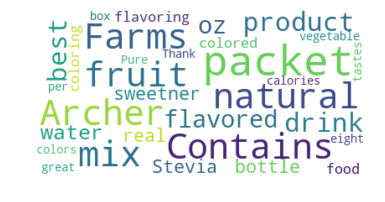

Review -  2
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


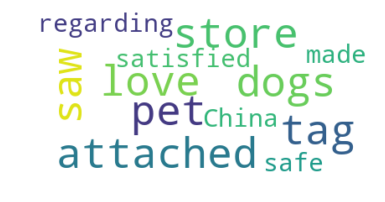

****************************************************************************************************


****************************** DBSCAN with EPS =  2    ******************************
DBSCAN with EPS =2.000 and min_pts = 296 the no. of Clusters = 1
****************************************************************************************************
Reviews of cluster =  1
****************************************************************************************************
Review -  1
This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!


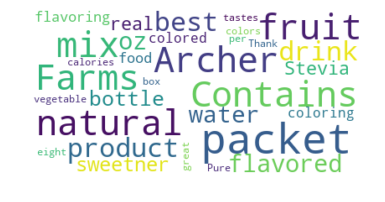

Review -  2
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


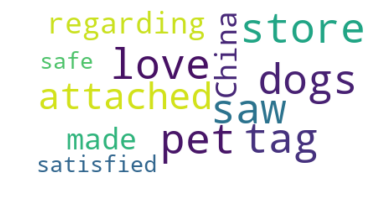

****************************************************************************************************




In [133]:
eps_list = [0.7,1.2,1.4,1.5,2]
DBSCAN_implementation_different_eps(eps_list,min_pts,tfidf_sent_vectors)

## Conclusion:
#### 1. As compared to the K-Means and Agglomerative Clustering, DBSCAN is a better choice in terms of Noise and non globular shapes.
#### It has handled noisy points(i.e having the labels as '-1') very well.